# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 0

### Writting the fields from files

In [1]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

# Import relevant modules
import sys
sys.path.append('..')

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


In [2]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [3]:
print(np.shape(ux))

(64, 16384, 9)


In [4]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']

t_steps = np.shape(ux)[0]

In [5]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))

(64, 128, 128, 9)


## Step 1

### We write the relevant magnitude in LC coordinates

In [6]:
# We define a function that, given a set of gauge links, returns the values over the x^+ axis

def get_xplus_axis_links (u):
    uminus = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))
    for t in range (t_steps):
        uminus[t, :, :] = u[t,t,:,:]
    uplus = np.apply_along_axis(su.dagger, 2, uminus)
    return uplus, uminus

In [7]:
u_plus_temp, u_minus_temp = get_xplus_axis_links(ux_r)

print(np.shape(u_plus_temp))
print(np.shape(u_minus_temp))

(64, 128, 9)
(64, 128, 9)


/n/work00/davrames/condacurraun/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 376:
@myjit
def dagger(a):
^

  state.func_ir.loc))


## Step 2

### We gauge transform the relevant quantity to LC gauge

In [8]:
# We construct a function that gives the gauge operator at a given point

def gauge_operator(u, xplus, xminus):
    v = su.GROUP_TYPE(np.array([su.unit() for i in range(N)]))
    for t in range(xplus+xminus):
        buffer1 = v
        aux = u[t, 2*xplus-t, :, :]
        buffer2 = np.apply_along_axis(su.dagger, 1, aux)
        v = np.array([su.mul(buffer1[i, :], buffer2[i, :]) for i in range(N)])
    return v

In [9]:
# We construct an array with the gauge operator over the x^+ axis

v_LC = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))

for t in range (t_steps):
    v_LC[t,:,:] = gauge_operator(ux_r, t, 0)

print(np.shape(v_LC))

/n/work00/davrames/condacurraun/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 400:
@myjit
def unit():
^

  state.func_ir.loc))
/n/work00/davrames/condacurraun/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  state.func_ir.loc))


(64, 128, 9)


In [10]:
# We construct a function that performs the gauge transformation of the plus links

def act_plus_link (u,v):
    v_h = np.apply_along_axis(su.dagger, 2, v)
    buffer1 = np.array([[su.mul(v[t+1, i, :], u[t, i, :]) for i in range(N)] for t in range(t_steps-1)]) #TODO: What happens with the last step?
    result =  np.array([[su.mul(buffer1[t, i, :], v_h[t, i, :]) for i in range(N)] for t in range(t_steps-1)])
    return result

In [11]:
# We transform the plus link

uplus_LC = act_plus_link(u_plus_temp, v_LC)

print(np.shape(uplus_LC))

(63, 128, 9)


In [12]:
# We plot U_+ at one point of the axis to have some intuition about its value

uplus_LC_r = uplus_LC.reshape((t_steps-1, N, 3, 3))
print(uplus_LC_r[t_steps//2, N//2, :])

[[ 9.77469277e-01+0.12189837j -1.00256275e-01+0.04577707j
  -5.88726903e-02-0.11866653j]
 [ 1.20945556e-01+0.05412687j  9.61823711e-01-0.1616666j
   4.74477447e-04+0.17663887j]
 [ 6.76759851e-02-0.0869311j   2.03708597e-02+0.19025569j
   9.74463342e-01+0.04088937j]]


Close to the identity but not exactly

- - -
We write the $U_+$ gauge link to file

In [13]:
np.savez_compressed('uplus_lc_gauge_transf.npz', uplus=uplus_LC)

Output $U_-$ in a format that is appropriate to be read in C++.

In [16]:
np.save('uplus_lc_gauge_transf.npy', uplus_LC)

In [17]:
np.save('uplus_lc_gauge_transf_time_slice.npy', uplus_LC[0,:,:])

In [22]:
uplus_LC[10,17,:]

array([ 0.98540433-0.01465645j,  0.05555779+0.10766926j,
       -0.08772258+0.07993065j, -0.06103636+0.11230477j,
        0.9868802 -0.03568809j, -0.05860681+0.07086093j,
        0.0728335 +0.08438591j,  0.05309051+0.08541597j,
        0.98743578+0.04929902j])

## Step 3

### We transform $U_-$ to LC gauge as a check

In [15]:
# We construct a function with the gauge operator at the next x^- step to the x^+ axis

aux = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))

for t in range (t_steps):
    aux[t,:,:] = gauge_operator(ux_r, t, 1)

print(np.shape(aux))

(64, 128, 9)


In [16]:
# We construct a function that performs the gauge transformation of the minus links

def act_minus_links(u, v, vplus1): #TODO: Writte the function with only u and v as inputs?
    v_h = np.apply_along_axis(su.dagger, 2, v)
    buffer1 = np.array([[su.mul(vplus1[t, i, :], u[t, i, :]) for i in range(N)] for t in range(t_steps-1)]) #TODO: What happens with the last step?
    result =  np.array([[su.mul(buffer1[t, i, :], v_h[t, i, :]) for i in range(N)] for t in range(t_steps-1)])
    return result

In [17]:
# We transform the minus link

uminus_LC = act_minus_links(u_minus_temp, v_LC, aux)

print(np.shape(uminus_LC))

(63, 128, 9)


In [18]:
# We plot U_- at one point of the axis to check that it is close to identity

uminus_LC_r = uminus_LC.reshape((t_steps-1, N, 3, 3))
print(uminus_LC_r[t_steps//2, N//2, :, :])

[[ 1.00000000e+00+1.04037499e-17j -2.13717932e-15+3.13727410e-15j
   1.94289029e-16-5.01391308e-15j]
 [-2.16493490e-15-3.14264487e-15j  1.00000000e+00-6.10934549e-18j
   2.66453526e-15-1.41494329e-14j]
 [ 3.05311332e-16+4.92670506e-15j  2.66453526e-15+1.40610269e-14j
   1.00000000e+00+2.28012149e-17j]]


The gauge links in minus direction are indeed transformed to the identity. Much closer to 1 that $U_+$ links

# Step 4

### We plot the transformed links

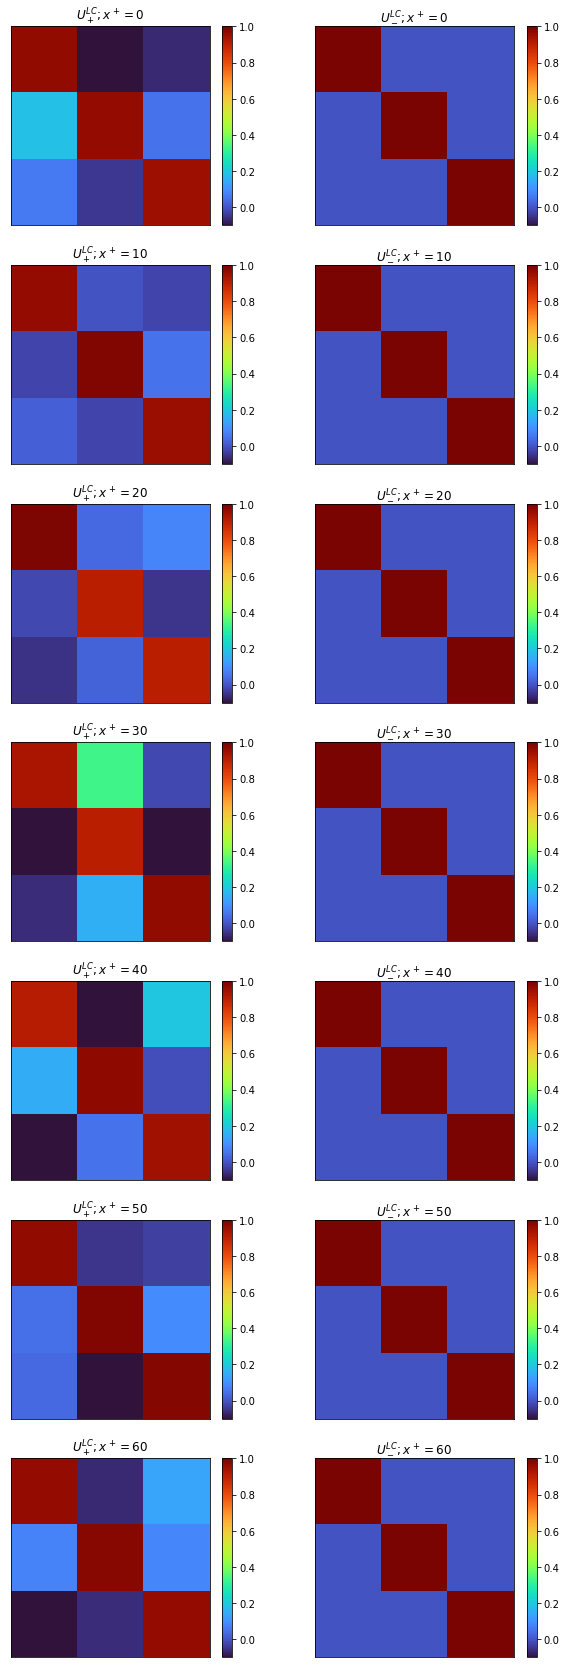

In [19]:
import matplotlib.pyplot as plt 

y = N//2

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_r[tau, y, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uminus_LC_r[tau, y, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,1].set_title(r'$U_-^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)